# Introduction

Look at properties of stratification

# Dependencies

In [233]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



# Create distributions

We create two normal distributions and then aggregate the distributions together.  This represents for example, exam scores from students that have rich parents or poor parents.

In [234]:
a = np.random.normal(1, 2**2, 500)
b = np.random.normal(5, 2**2, 500)

ab = np.concatenate((a, b))

<AxesSubplot:ylabel='Density'>

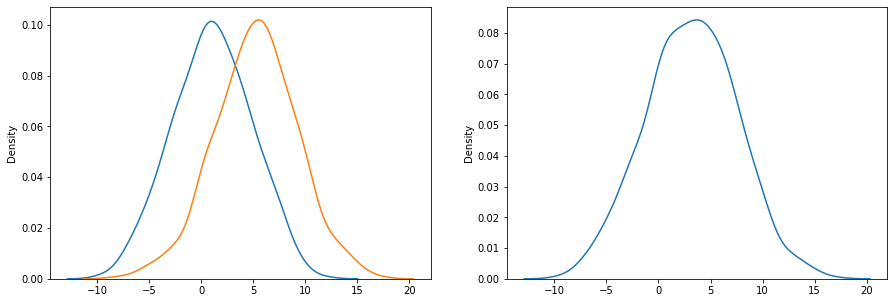

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(a, ax=ax[0])
sns.kdeplot(b, ax=ax[0])
sns.kdeplot(ab, ax=ax[1])

The sum of the two distributions on the left represent the distribution on the right.  How do their means differ?

# Calculate estimates

Here we calculate the mean, variance, and variance of the mean for aggregate and weighted strata data.

In [248]:
mean = ab.mean()
var = ab.var()
var_m = ab.var()/len(ab)

wt_mean = a.mean()*len(a)/len(ab) + b.mean()*len(b)/len(ab) 
wt_var = a.var()*len(a)/len(ab) + b.var()*len(b)/len(ab) 
wt_var_m = a.var() / len(a) * (len(a)/len(ab))**2 + b.var() / len(b) * (len(b)/len(ab))**2

print('mean: {:.3f}, var: {:.3f}, var_m: {:.3f}'.format(mean, var, var_m))
print()


print('weighted mean: {:.3f}, weighted var: {:.3f}, weighted var_m: {:.3f}'.format(wt_mean, wt_var, wt_var_m))

print()
print('var_reduction: {:.0%}'.format(1 - wt_var/var))
print('var_m_reduction: {:.0%}'.format(1 - wt_var_m/var_m))

mean: 2.866, var: 18.478, var_m: 0.018

weighted mean: 2.866, weighted var: 15.034, weighted var_m: 0.015

var_reduction: 19%
var_m_reduction: 19%


We can see that we have the same mean but the variance is reduced.  We see a ~20% reduction in variance because the weights used for the weighted estimates account for the variance between the strata, leaving the variance within the stratas.

# Iterate over differnt means and weights

Now we create functions to perform what we did above so we can easily iterate through several examples.

In [249]:
def create_distributions(
        mean_a, sd_a, n_a,
        mean_b, sd_b, n_b,
) -> tuple:
        
    a = np.random.normal(mean_a, sd_a**2, n_a)
    b = np.random.normal(mean_b, sd_b**2, n_b)

    ab = np.concatenate((a, b))

    return a, b, ab

def calc_estimates(a, b, ab):
    mean = ab.mean()
    var = ab.var()
    var_m = ab.var() / len(ab)
     
    wt_mean = a.mean()*len(a)/len(ab) + b.mean()*len(b)/len(ab) 
    wt_var = a.var()*len(a)/len(ab) + b.var()*len(b)/len(ab)
    wt_var_m = a.var() / len(a) * (len(a)/len(ab))**2 + b.var() / len(b) * (len(b)/len(ab))**2
     
    df = pd.DataFrame(
        {
            'mean': [mean],
            'var': [var],
            'var_m': [var_m],
            'wt_mean': [wt_mean],
            'wt_var': [wt_var],
            'wt_var_m': [wt_var_m]
        }
    )

    df['var_reduction'] = (1 - df['wt_var'] / df['var']) * 100
    df['var_m_reduction'] = (1 - df['wt_var_m'] / df['var_m']) * 100

    return df

When the variances are similar between the strata and the means differ, then we see variance reduction.  

,mean,var,var_m,wt_mean,wt_var,wt_var_m,var_reduction,var_m_reduction
0,3.065534,20.64831,0.020648,3.065534,17.220595,0.017221,16.600462,16.600462


<AxesSubplot:ylabel='Density'>

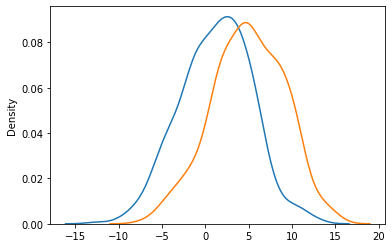

In [256]:
a, b, ab = create_distributions(1, 2, 500, 5, 2, 500)
df = calc_estimates(a, b, ab)

display(df)

sns.kdeplot(a)
sns.kdeplot(b)

When we have the same estimate but the variances differ, there is no variance reduction.  

,mean,var,var_m,wt_mean,wt_var,wt_var_m,var_reduction,var_m_reduction
0,1.063344,132.884151,0.013288,1.063344,132.879424,0.013288,0.003557,0.003557


<AxesSubplot:ylabel='Density'>

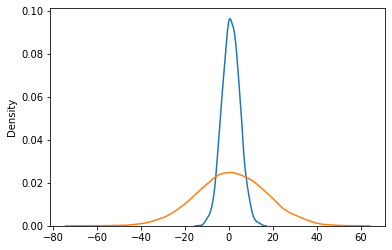

In [257]:
a, b, ab = create_distributions(1, 2, 5000, 1, 4, 5000)
df = calc_estimates(a, b, ab)

display(df)

sns.kdeplot(a)
sns.kdeplot(b)

When the variance increases within strata, the variance reduction is worse even if stratas have different means.  Graphically, we can see the distributions have less separation.

,mean,var,var_m,wt_mean,wt_var,wt_var_m,var_reduction,var_m_reduction
0,2.920092,138.195158,0.01382,2.920092,134.613886,0.013461,2.59146,2.59146


<AxesSubplot:ylabel='Density'>

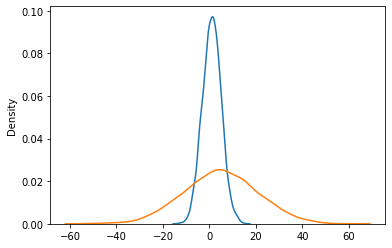

In [258]:
a, b, ab = create_distributions(1, 2, 5000, 5, 4, 5000)
df = calc_estimates(a, b, ab)

display(df)

sns.kdeplot(a)
sns.kdeplot(b)

We can see that both the mean of the individual distributions as well as the variance affects the variance reduction of stratification.  When difference between the means of the strata are large, more of the total variance is accounted for from inter strata variance.  But as the within strata variance increases, the inter strata variance contributes less to the total variance and so the variance reduction is smaller.

Let's see the variance reduction if the mean was 10x larger but the standard deviation varied.

In [259]:
simu_df = pd.DataFrame()
sd_b_mul = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]

for mul in sd_b_mul:
    a, b, ab = create_distributions(1, 2, 5000, 10, 2*mul, 5000)

    df = calc_estimates(a, b, ab)
    simu_df = pd.concat([simu_df, df])

simu_df = simu_df.reset_index(drop=True)
simu_df['sd_b_mul'] = sd_b_mul
simu_df['var_b_mul'] = np.array(sd_b_mul)**2

In [260]:
simu_df

,mean,var,var_m,wt_mean,wt_var,wt_var_m,var_reduction,var_m_reduction,sd_b_mul,var_b_mul
0,5.529567,36.334132,0.003633,5.529567,15.777499,0.001578,56.576645,56.576645,1.00,1.0000
1,5.564514,47.753010,0.004775,5.564514,27.406838,0.002741,42.607099,42.607099,1.25,1.5625
2,5.605595,69.975645,0.006998,5.605595,48.672076,0.004867,30.444262,30.444262,1.50,2.2500
3,5.516482,103.438044,0.010344,5.516482,83.141985,0.008314,19.621464,19.621464,1.75,3.0625
4,5.434103,159.385218,0.015939,5.434103,139.341726,0.013934,12.575502,12.575502,2.00,4.0000
5,5.475578,345.021339,0.034502,5.475578,324.160037,0.032416,6.046380,6.046380,2.50,6.2500
6,5.506065,667.764225,0.066776,5.506065,647.519520,0.064752,3.031714,3.031714,3.00,9.0000


<AxesSubplot:xlabel='var_b_mul', ylabel='var_reduction'>

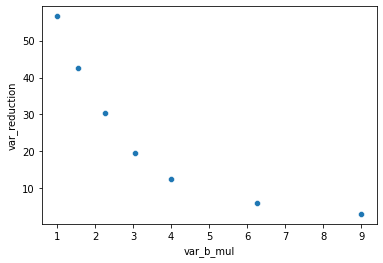

In [261]:
sns.scatterplot(data=simu_df, x='var_b_mul', y='var_reduction')

When the variance of the second strata is 4x larger, the variance reduction is roughly 4x smaller (e.g. 56% --> 13%).  Since the variance of the mean is just scaled by the root of the sample size, as long as we see variance reduction in the underlying sample, we see the sample variance reduction for the variance of the mean.

Consequently we need to find strata separates well for variance reduction.  For example, the mean of the strata increases and the variances are smaller.

# End